In [ ]:
!pip install transformers datasets wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset
from transformers import Trainer, TrainingArguments
from tqdm import tqdm
import wandb
import time
import math

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
raw_datasets = load_dataset("stanfordnlp/sst2")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
def tokenize_function(example):
    return tokenizer(example['sentence'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print(tokenized_datasets)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1821
    })
})


In [ ]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)
resume_training = False
model_name = 'bert-base-uncased'

if resume_training:
    classifier = AutoModelForSequenceClassification.from_pretrained('./results/').to(device)
else:
    classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

print("Model is ready for training.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model is ready for training.


In [ ]:
class ModifiedTrainer(Trainer):
    def _inner_training_loop(
        self,
        batch_size=None,
        args=None,
        resume_from_checkpoint=None,
        trial=None,
        ignore_keys_for_eval=None
    ):
        epochs = int(args.num_train_epochs)
        start_time = time.time()

        loss_function = torch.nn.CrossEntropyLoss().to(device)
        optimizer = torch.optim.Adam(classifier.parameters(), lr=args.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

        train_loader = self.get_train_dataloader()
        eval_loader = self.get_eval_dataloader()

        for epoch in range(epochs):
            epoch_loss = 0
            epoch_accuracy = 0
            classifier.train()
            with tqdm(train_loader, unit='batch') as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}/{epochs} [Training]")
                for batch in tepoch:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    labels = batch['labels']

                    optimizer.zero_grad()
                    outputs = classifier(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask']
                    )

                    loss = loss_function(outputs.logits, labels)
                    epoch_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                    predictions = outputs.logits.argmax(dim=-1)
                    correct = (predictions == labels).sum().item()
                    epoch_accuracy += correct

                    wandb.log({"Batch Training Loss": loss.item()})

            scheduler.step()

            avg_loss = epoch_loss / len(train_loader)
            avg_accuracy = epoch_accuracy / (len(train_loader.dataset))

            wandb.log({
                "Epoch Training Loss": avg_loss,
                "Epoch Training Accuracy": avg_accuracy,
                "Epoch": epoch + 1
            })
            classifier.eval()
            eval_loss = 0
            eval_accuracy = 0
            with tqdm(eval_loader, unit='batch') as eepoch:
                eepoch.set_description(f"Epoch {epoch+1}/{epochs} [Evaluation]")
                for batch in eepoch:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    labels = batch['labels']

                    with torch.no_grad():
                        outputs = classifier(
                            input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask']
                        )

                    loss = loss_function(outputs.logits, labels)
                    eval_loss += loss.item()

                    predictions = outputs.logits.argmax(dim=-1)
                    correct = (predictions == labels).sum().item()
                    eval_accuracy += correct

            avg_eval_loss = eval_loss / len(eval_loader)
            avg_eval_accuracy = eval_accuracy / (len(eval_loader.dataset))

            wandb.log({
                "Epoch Evaluation Loss": avg_eval_loss,
                "Epoch Evaluation Accuracy": avg_eval_accuracy,
                "Epoch": epoch + 1
            })

            print(f"Epoch {epoch+1} Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_accuracy:.4f}")
            print(f"Epoch {epoch+1} Evaluation Loss: {avg_eval_loss:.4f}, Evaluation Accuracy: {avg_eval_accuracy:.4f}")

        total_time = (time.time() - start_time) / 60
        print(f"Training completed in {total_time:.2f} minutes.")

In [ ]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['WANDB_NOTEBOOK_NAME'] = 'hero.ipynb'

In [ ]:
wandb_config = {
    'epochs': 6,
    'num_classes': 2,
    'batch_size': 128,
    'learning_rate': 2e-5,
    'dataset': 'SST-2',
    'model_architecture': 'BERT'
}

In [ ]:
if not resume_training:
    with wandb.init(project='results', name='Run_Modified_Code', config=wandb_config):
        training_args = TrainingArguments(
            output_dir='./results',
            learning_rate=wandb.config.learning_rate,
            num_train_epochs=wandb.config.epochs,
            per_device_train_batch_size=wandb.config.batch_size,
            per_device_eval_batch_size=wandb.config.batch_size
        )
        trainer = ModifiedTrainer(
            model=classifier,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation'],
            tokenizer=tokenizer,
            data_collator=collator,
        )
        trainer.train()
        classifier.save_pretrained('./results/')

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find hero.ipynb.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/6 [Evaluation]: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Epoch 1 Training Loss: 0.2314, Training Accuracy: 0.9069
Epoch 1 Evaluation Loss: 0.2201, Evaluation Accuracy: 0.9128


Epoch 2/6 [Evaluation]: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Epoch 2 Training Loss: 0.1169, Training Accuracy: 0.9593
Epoch 2 Evaluation Loss: 0.2493, Evaluation Accuracy: 0.9174


Epoch 3/6 [Evaluation]: 100%|██████████| 7/7 [00:01<00:00,  6.23batch/s]


Epoch 3 Training Loss: 0.0811, Training Accuracy: 0.9720
Epoch 3 Evaluation Loss: 0.2470, Evaluation Accuracy: 0.9197


Epoch 4/6 [Evaluation]: 100%|██████████| 7/7 [00:01<00:00,  6.24batch/s]


Epoch 4 Training Loss: 0.0595, Training Accuracy: 0.9799
Epoch 4 Evaluation Loss: 0.2251, Evaluation Accuracy: 0.9278


Epoch 5/6 [Evaluation]: 100%|██████████| 7/7 [00:01<00:00,  6.21batch/s]


Epoch 5 Training Loss: 0.0450, Training Accuracy: 0.9844
Epoch 5 Evaluation Loss: 0.2530, Evaluation Accuracy: 0.9243


Epoch 6/6 [Evaluation]: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Epoch 6 Training Loss: 0.0337, Training Accuracy: 0.9886
Epoch 6 Evaluation Loss: 0.2717, Evaluation Accuracy: 0.9209
Training completed in 21.49 minutes.


Batch Training Loss,█▅▃▄▃▃▃▂▃▃▂▂▂▂▂▂▃▂▁▁▁▂▁▁▁▂▁▂▁▂▂▁▁▁▂▁▁▂▁▁
Epoch,▁▁▂▂▄▄▅▅▇▇██
Epoch Evaluation Accuracy,▁▃▄█▆▅
Epoch Evaluation Loss,▁▅▅▂▅█
Epoch Training Accuracy,▁▅▇▇██
Epoch Training Loss,█▄▃▂▁▁
Batch Training Loss,0.04033
Epoch,6
Epoch Evaluation Accuracy,0.92087
Epoch Evaluation Loss,0.27171
Epoch Training Accuracy,0.98861


In [ ]:
import pandas as pd
from torch.utils.data import DataLoader

incorrect_predictions_df = pd.DataFrame(columns=[
    'Text', 'Actual Label', 'Predicted Label', 'Confidence Score',
    'Error Type', 'Error Cause', 'Potential Solution'
])
test_dataset = tokenized_datasets['validation'].remove_columns(['sentence', 'token_type_ids'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collator)

classifier.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = classifier(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predictions = outputs.logits.argmax(dim=-1)

        for idx, (pred, label, prob) in enumerate(zip(predictions, batch['labels'], probs)):
            if pred != label:
                error_type = 'False Positive' if label.item() == 0 else 'False Negative'
                new_entry = {
                    'Text': raw_datasets['validation']['sentence'][batch['idx'][idx]],
                    'Actual Label': label.item(),
                    'Predicted Label': pred.item(),
                    'Confidence Score': prob.max().item(),
                    'Error Type': error_type
                }
                incorrect_predictions_df = pd.concat([incorrect_predictions_df, pd.DataFrame([new_entry])], ignore_index=True)
        # if len(incorrect_predictions_df) > 10:
        #     break
incorrect_predictions_df.to_csv('incorrect_predictions.csv', index=False)

<ipython-input-11-e12d5a4d2eaf>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  incorrect_predictions_df = pd.concat([incorrect_predictions_df, pd.DataFrame([new_entry])], ignore_index=True)


In [ ]:
def single_prediction(text):
    start = time.time()
    inputs = tokenizer(text, return_tensors='pt').to(device)
    outputs = classifier(**inputs)
    prediction = outputs.logits.argmax(dim=-1).item()
    sentiment = "Positive" if prediction == 1 else "Negative"
    duration = time.time() - start
    return sentiment, duration

sample_text = "I absolutely adore studying natural language processing!"
result, latency = single_prediction(sample_text)
print(f"Model Prediction for '{sample_text}': {result}")
print(f"Inference Time: {latency*1000:.2f} ms")

Model Prediction for 'I absolutely adore studying natural language processing!': Positive
Inference Time: 75.58 ms


In [ ]:
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

test_dataset = tokenized_datasets['validation'].remove_columns(['sentence', 'token_type_ids'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collator)
correct_pos_embeds = []
correct_neg_embeds = []
incorrect_embeds = []
correct_pos_confidence = []
correct_neg_confidence = []
incorrect_confidence = []

classifier.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = classifier(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            output_hidden_states=True
        )
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predictions = outputs.logits.argmax(dim=-1)
        hidden_states = outputs.hidden_states[-1][:, 0, :].cpu()  # CLS token embeddings

        for idx, (pred, label, prob, embed) in enumerate(zip(predictions, batch['labels'], probs, hidden_states)):
            confidence = prob.max().item()
            if pred == label:
                if label.item() == 1:
                    correct_pos_embeds.append(embed.numpy())
                    correct_pos_confidence.append(confidence)
                else:
                    correct_neg_embeds.append(embed.numpy())
                    correct_neg_confidence.append(confidence)
            else:
                incorrect_embeds.append(embed.numpy())
                incorrect_confidence.append(confidence)

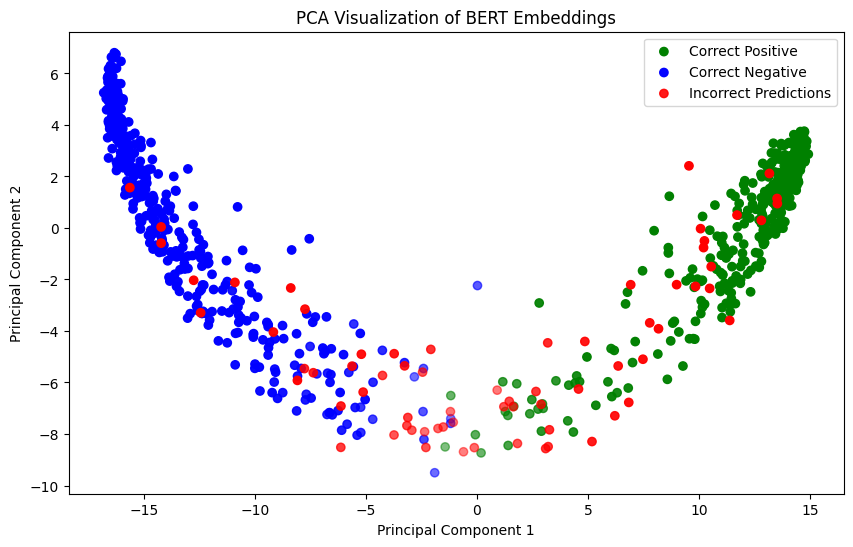

In [ ]:
pca = PCA(n_components=2)
all_embeddings = correct_pos_embeds + correct_neg_embeds + incorrect_embeds
pca.fit(all_embeddings)

correct_pos_pca = pca.transform(correct_pos_embeds)
correct_neg_pca = pca.transform(correct_neg_embeds)
incorrect_pca = pca.transform(incorrect_embeds)
plt.figure(figsize=(10, 6))
plt.scatter(
    correct_pos_pca[:, 0], correct_pos_pca[:, 1],
    c='green', alpha=correct_pos_confidence, label='Correct Positive'
)
plt.scatter(
    correct_neg_pca[:, 0], correct_neg_pca[:, 1],
    c='blue', alpha=correct_neg_confidence, label='Correct Negative'
)
plt.scatter(
    incorrect_pca[:, 0], incorrect_pca[:, 1],
    c='red', alpha=incorrect_confidence, label='Incorrect Predictions'
)
plt.title('PCA Visualization of BERT Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()